# Лабораторная работа №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)
Выполнил: Таланкин Кирилл Александрович
Группа: М8О-309Б-23
Датасет: https://www.kaggle.com/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024

## 0. Выбор модели
Выбрана модель: Random Forest Regressor (для предсказания объема продаж).

## 1. Гиперпараметры модели

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import optuna
import shap
import lime.lime_tabular as lime_tabular
import warnings
warnings.filterwarnings("ignore")

params_table = pd.DataFrame([
    ["n_estimators", "Количество деревьев в лесу"],
    ["max_depth", "Максимальная глубина дерева"],
    ["min_samples_split", "Минимум объектов для разбиения узла"],
    ["min_samples_leaf", "Минимум объектов в листе"],
    ["max_features", "Число признаков для поиска лучшего сплита"]
], columns=["Гиперпараметр", "Описание"])

print("Таблица основных гиперпараметров RandomForestRegressor:")
print(params_table)

Таблица основных гиперпараметров RandomForestRegressor:
       Гиперпараметр                                   Описание
0       n_estimators                 Количество деревьев в лесу
1          max_depth                Максимальная глубина дерева
2  min_samples_split        Минимум объектов для разбиения узла
3   min_samples_leaf                   Минимум объектов в листе
4       max_features  Число признаков для поиска лучшего сплита


## 2. Подготовка данных
Загрузка и очистка датасета, разделение на признаки и целевую переменную.

In [4]:
df = pd.read_csv("BMW_sales_data.csv")
df_clean = df[["Model", "Year", "Region", "Color", "Fuel_Type", "Transmission", "Engine_Size_L", "Mileage_KM", "Price_USD", "Sales_Volume"]].replace(0, np.nan).dropna()

X = df_clean.drop("Sales_Volume", axis=1)
y = df_clean["Sales_Volume"]

## Создание пайплайна

In [5]:
categorical_features = ["Model", "Region", "Color", "Fuel_Type", "Transmission"]
numerical_features = ["Year", "Engine_Size_L", "Mileage_KM", "Price_USD"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

base_model = RandomForestRegressor(random_state=42)
pipe = Pipeline([("preprocessor", preprocessor), ("model", base_model)])

## 3. Подбор гиперпараметров
### Grid Search

In [6]:
grid_params = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

def evaluate_model(pipe_obj, X_data, y_data):
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    pipe_obj.fit(X_train, y_train)
    preds = pipe_obj.predict(X_val)
    return mean_squared_error(y_val, preds)

grid = GridSearchCV(pipe, grid_params, cv=3, n_jobs=-1)
grid.fit(X, y)
grid_best_params = grid.best_params_
grid_mse = evaluate_model(grid.best_estimator_, X, y)
print("Лучшие параметры GridSearch:")
print(grid_best_params)
print("MSE GridSearch:", grid_mse)

Лучшие параметры GridSearch:
{'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 300}
MSE GridSearch: 8174112.151715021


### Random Search

In [7]:
rand_params = {
    "model__n_estimators": [50, 100, 200, 400],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10]
}

random_search = RandomizedSearchCV(pipe, rand_params, cv=3, n_iter=10, n_jobs=-1)
random_search.fit(X, y)
random_best_params = random_search.best_params_
random_mse = evaluate_model(random_search.best_estimator_, X, y)
print("Лучшие параметры RandomSearch:")
print(random_best_params)
print("MSE RandomSearch:", random_mse)

Лучшие параметры RandomSearch:
{'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__max_depth': 5}
MSE RandomSearch: 8174370.207645172


### Optuna Search

In [9]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
    }
    model = RandomForestRegressor(
        random_state=42,
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"]
    )
    pipe_opt = Pipeline([("preprocessor", preprocessor), ("model", model)])
    return evaluate_model(pipe_opt, X, y)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)
optuna_best_params = study.best_params
optuna_mse = study.best_value
print("Лучшие параметры Optuna:")
print(optuna_best_params)
print("MSE Optuna:", optuna_mse)

[I 2025-11-29 22:13:49,588] A new study created in memory with name: no-name-134f5f81-9a84-46af-b040-4fac58013b16
[I 2025-11-29 22:16:59,920] Trial 0 finished with value: 8236602.80029978 and parameters: {'n_estimators': 262, 'max_depth': 19, 'min_samples_split': 8}. Best is trial 0 with value: 8236602.80029978.
[I 2025-11-29 22:27:04,349] Trial 1 finished with value: 8299592.8272013245 and parameters: {'n_estimators': 393, 'max_depth': 25, 'min_samples_split': 3}. Best is trial 0 with value: 8236602.80029978.
[I 2025-11-29 22:30:58,520] Trial 2 finished with value: 8282004.9786514435 and parameters: {'n_estimators': 220, 'max_depth': 25, 'min_samples_split': 9}. Best is trial 0 with value: 8236602.80029978.
[I 2025-11-29 22:32:50,477] Trial 3 finished with value: 8214315.3731600465 and parameters: {'n_estimators': 188, 'max_depth': 16, 'min_samples_split': 4}. Best is trial 3 with value: 8214315.3731600465.
[I 2025-11-29 22:35:15,989] Trial 4 finished with value: 8223594.687890846 and

Лучшие параметры Optuna:
{'n_estimators': 146, 'max_depth': 5, 'min_samples_split': 6}
MSE Optuna: 8173015.040702636


## Сравнение методов подбора гиперпараметров

In [10]:
results = pd.DataFrame([
    ["GridSearch", grid_best_params, grid_mse],
    ["RandomSearch", random_best_params, random_mse],
    ["Optuna", optuna_best_params, optuna_mse]
], columns=["Метод", "Лучшие параметры", "MSE"])

print("Сравнение методов подбора гиперпараметров:")
print(results)

Сравнение методов подбора гиперпараметров:
          Метод                                   Лучшие параметры  \
0    GridSearch  {'model__max_depth': 5, 'model__min_samples_sp...   
1  RandomSearch  {'model__n_estimators': 400, 'model__min_sampl...   
2        Optuna  {'n_estimators': 146, 'max_depth': 5, 'min_sam...   

            MSE  
0  8.174112e+06  
1  8.174370e+06  
2  8.173015e+06  


## Лучший метод подбора гиперпараметров

In [17]:
best_row = results.loc[results["MSE"].idxmin()]
best_method_name = best_row["Метод"]
print("Лучший метод подбора гиперпараметров:")
print("Метод:", best_method_name)
print("Лучшие параметры:", best_row["Лучшие параметры"])
print("Лучшее MSE:", best_row["MSE"])

if best_method_name == "GridSearch":
    best_pipe = grid.best_estimator_
elif best_method_name == "RandomSearch":
    best_pipe = random_search.best_estimator_
else:
    best_model = RandomForestRegressor(
        random_state=42,
        n_estimators=optuna_best_params["n_estimators"],
        max_depth=optuna_best_params["max_depth"],
        min_samples_split=optuna_best_params["min_samples_split"]
    )
    best_pipe = Pipeline([("preprocessor", preprocessor), ("model", best_model)])

best_pipe.fit(X, y)

Лучший метод подбора гиперпараметров:
Метод: Optuna
Лучшие параметры: {'n_estimators': 146, 'max_depth': 5, 'min_samples_split': 6}
Лучшее MSE: 8173015.040702636


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Глобальная интерпретация SHAP

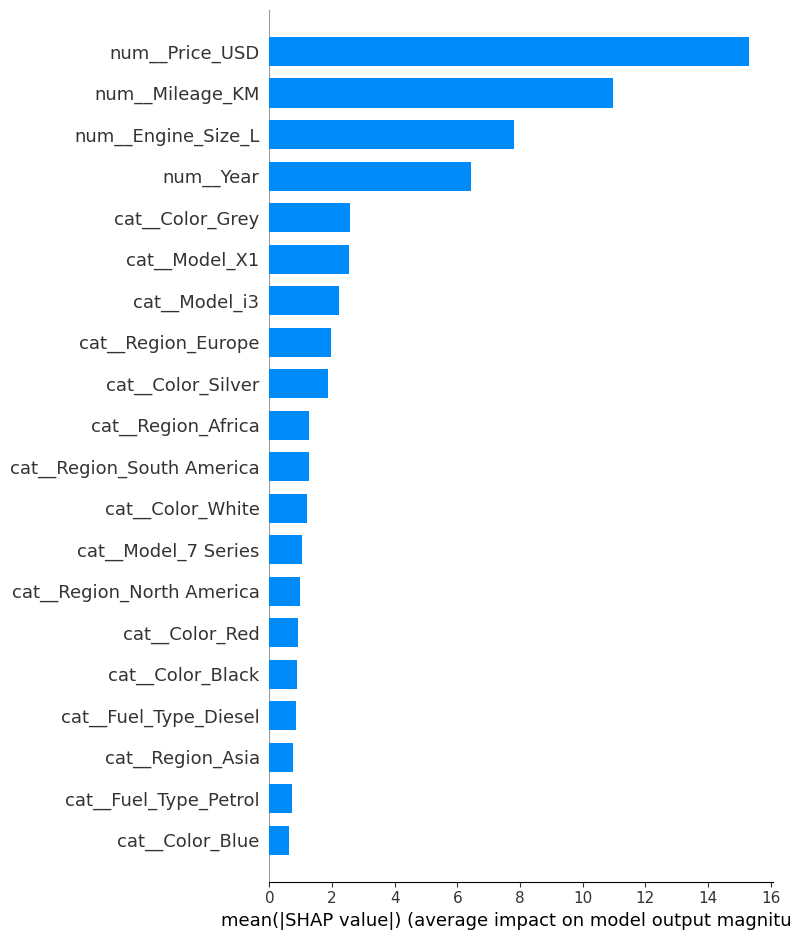

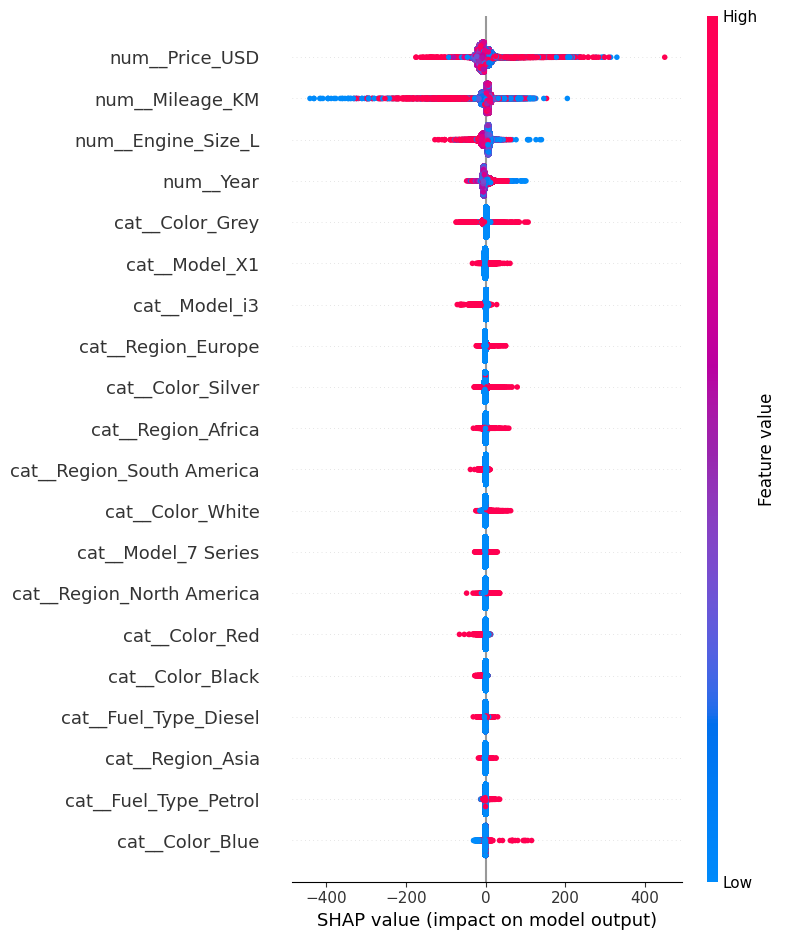

In [13]:
explainer = shap.TreeExplainer(best_pipe.named_steps["model"])
X_transformed = best_pipe.named_steps["preprocessor"].transform(X).toarray()
shap_values = explainer.shap_values(X_transformed)

feature_names = best_pipe.named_steps["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

## Локальная интерпретация LIME

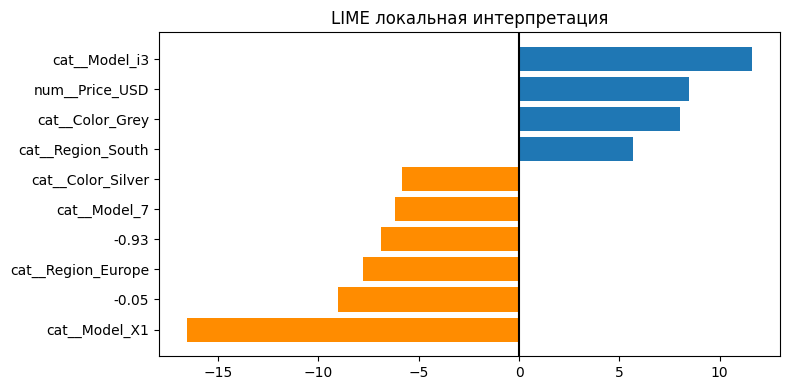

In [14]:
feature_names = best_pipe.named_steps["preprocessor"].get_feature_names_out()
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    mode="regression"
)

def pipe_predict_from_lime(x):
    return best_pipe.named_steps["model"].predict(x)

def plot_lime_explanation(exp):
    exp_list = exp.as_list()
    lime_df = pd.DataFrame(exp_list, columns=["Feature", "Contribution"])
    lime_df["Feature"] = lime_df["Feature"].apply(lambda s: s.split(" ")[0])
    lime_df = lime_df.sort_values("Contribution", ascending=True)
    colors = lime_df["Contribution"].apply(lambda v: "#ff8c00" if v < 0 else "#1f77b4")
    plt.figure(figsize=(8, 4))
    plt.barh(lime_df["Feature"], lime_df["Contribution"], color=colors)
    plt.axvline(0, color="black")
    plt.title("LIME локальная интерпретация")
    plt.tight_layout()
    plt.show()

exp_sample = lime_explainer.explain_instance(X_transformed[0], pipe_predict_from_lime)
plot_lime_explanation(exp_sample)

## Калькулятор предсказания с интерпретацией


Прогноз продаж BMW:
5,083 единиц


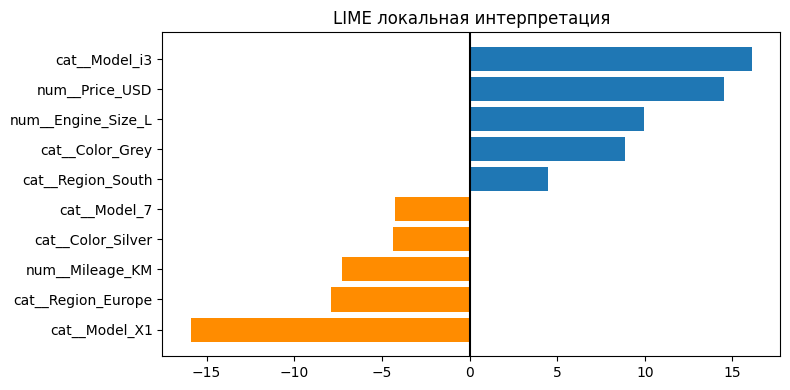

(np.float64(5083.290575254299),
 <lime.explanation.Explanation at 0x1de595ac550>)

In [16]:
def bmw_predict(Model, Year, Region, Color, Fuel_Type, Transmission, Engine_Size_L, Mileage_KM, Price_USD):
    x = pd.DataFrame([{
        "Model": Model,
        "Year": Year,
        "Region": Region,
        "Color": Color,
        "Fuel_Type": Fuel_Type,
        "Transmission": Transmission,
        "Engine_Size_L": Engine_Size_L,
        "Mileage_KM": Mileage_KM,
        "Price_USD": Price_USD
    }])
    pred = best_pipe.predict(x)[0]
    x_t = best_pipe.named_steps["preprocessor"].transform(x).toarray()
    exp = lime_explainer.explain_instance(x_t[0], pipe_predict_from_lime)
    print("\nПрогноз продаж BMW:")
    print(f"{pred:,.0f} единиц")
    plot_lime_explanation(exp)
    return pred, exp

bmw_predict('5 Series', 2020, 'Asia', 'Red', 'Petrol', 'Manual', 2.0, 10000, 50000)